This is needed to reload modules without restarting the kernel

In [3]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [4]:
import os
os.sys.path.append('../../')

In [5]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
hep.set_style('ATLAS')

In [6]:
from eda_tools.utilities import getNorm

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
from scipy.spatial.distance import euclidean

In [8]:
from hh4b_utils.nnt_tools import load_nnt

In [9]:
from eda_tools.bkg_helper import bs_error

In [10]:
from scipy.stats import wasserstein_distance

# Optimization Results analysis

### Let's define a function to calculate $\chi^2$

In [11]:
def weighted_chisquare(f_obs, f_exp, f_obs_err, f_exp_err, ignore_stats = False, residuals=False, stat_lim = 10):
    #obs = 2b
    #exp = 4b
    
    from scipy.stats import chi2
    
    
    #Calculate weighted chi-square using method in arXiv:physics/0605123
    if ignore_stats == False:
        w1 = f_obs[(f_obs > stat_lim) | (f_exp > stat_lim)]
        w2 = f_exp[(f_obs > stat_lim) | (f_exp > stat_lim)]
        s1 = f_obs_err[(f_obs > stat_lim) | (f_exp > stat_lim)]  # noqa
        s2 = f_exp_err[(f_obs > stat_lim) | (f_exp > stat_lim)]  # noqa
    else:
        w1 = f_obs
        w2 = f_exp
        s1 = f_obs_err # noqa
        s2 = f_exp_err # noqa
    
    ndf = len(w1) - 1
    W1 = np.sum(w1)  # noqa
    W2 = np.sum(w2)  # noqa

    pi = (w1*W1 / (s1**2)) + (w2*W2/ (s2**2)) / (((W1**2)/(s1**2)) + ((W2**2)/(s2**2)))


    R = (W1*w2 - W2*w1)**2 / (W1**2 * s2**2 + W2**2 * s1**2)
    R = np.where(((np.isnan(R)) | (np.isinf(R))), 0, R)
    #X2 = np.sum((W1*w2 - W2*w1)**2 / (W1**2 * s2**2 + W2**2 * s1**2))
    X2 = np.sum(R)
    p_value = chi2.sf(X2, ndf)
    if residuals:
        frac = 1 + ((W2**2)*(s1**2))/((W1**2)/(s2**2))
        top = w1-W1*pi
        bottom = s1 * np.sqrt(1 - 1/frac)
        ri = top/bottom
        return (X2, p_value, ndf, X2/ndf, ri)
    else:
        return (X2, p_value, ndf, X2/ndf)

### Define a function for the shape systematic (might be useful later)

In [12]:
def shape_systematic(
    df: pd.DataFrame,
    feature: str,
    kr: int,
    bins=50,
    hrange=None,
    CR_weights: str = None,
    VR_weights: str = None,
) -> dict:

    mask_2b = df["ntag"] == 2
    mask_kr = df["kinematic_region"] == kr

    if CR_weights is None:
        CR_weights = df.filter(regex="NN_d24_weight_bstrap_med").columns.to_list()[0]

    if VR_weights is None:
        VR_weights = df.filter(
            regex="NN_d24_weight_VRderiv_bstrap_med"
        ).columns.to_list()[0]

    mu_cr = getNorm(df, k=2, weight_column=CR_weights)
    mu_vr = getNorm(df, k=1, weight_column=VR_weights)

    x = df.loc[mask_2b & mask_kr, feature].values
    w_cr = df.loc[mask_2b & mask_kr, CR_weights].values
    w_vr = df.loc[mask_2b & mask_kr, VR_weights].values

    cr_estimate, be = np.histogram(x, bins=bins, range=hrange, weights=mu_cr * w_cr)

    vr_estimate, _ = np.histogram(
        x,
        bins=be,
        range=hrange,
        weights=mu_vr * w_vr,
    )

    inv_estimate, _ = np.histogram(
        x, bins=be, range=hrange, weights=2 * mu_cr * w_cr - mu_vr * w_vr
    )
    results = {}
    results['cr_estimate'] = cr_estimate
    results['vr_estimate'] = vr_estimate
    results['inv_estimate'] = inv_estimate
    results['shape_err'] = np.abs(vr_estimate - cr_estimate)
    results['be'] = be
    
    return results

### Nominal Histogram Generation

In [13]:
 def histogram_4b(
    df: pd.DataFrame, feature: str, kinematic_region: int, bins=50, hrange: tuple = None
) -> dict:

    mask_kr = df["kinematic_region"] == kinematic_region
    mask_4b = df["ntag"] >= 4

    h_4b, be = np.histogram(
        df.loc[mask_kr & mask_4b, feature].values, bins=bins, range=hrange
    )
    h_4b_err = np.sqrt(h_4b)  # Poisson error (sqrt(N))
    _results = {"h_4b": h_4b, "h_4b_err": h_4b_err, "be_4b": be}
    return _results

In [14]:
def histogram_2b(
    df: pd.DataFrame,
    feature: str,
    kinematic_region: int,
    norm: float,
    weights_column: str=None,
    bins: int = 50,
    hrange: tuple = None,
) -> dict:

    mask_kr = df["kinematic_region"] == kinematic_region
    mask_2b = df["ntag"] == 2

    x = df.loc[mask_kr & mask_2b, feature].values
    if weights_column is not None:
        w = norm * df.loc[mask_kr & mask_2b, weights_column].values
    else:
        w = np.ones(x.shape[0])

    h_2b, be = np.histogram(x, bins=bins, range=hrange, weights=w)
    
    if weights_column is not None:
        # Poisson error of a weighted histogram
        h_2b_err_pois = np.histogram(x, bins=bins, weights=w ** 2)[0]
    else:
        h_2b_err_pois = np.sqrt(h_2b)

    _results = {"h_2b": h_2b, "h_2b_err_pois": h_2b_err_pois, "be_2b": be}
    return _results

In [15]:
def generate_histograms(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    norm: float,
    kinematic_region: int,
    weights_column: str,
) -> dict:

    histos_2b = np.array([])
    histos_4b = np.array([])
    error_2b = np.array([])
    error_4b = np.array([])
    emds = np.array([])
    for i, (feature, be) in enumerate(zip(features, bin_edges)):

        r4b = histogram_4b(
            df, feature=feature, kinematic_region=kinematic_region, bins=be
        )
        histos_4b = np.append(histos_4b, r4b["h_4b"])
        error_4b = np.append(error_4b, r4b["h_4b_err"])

        r2b = histogram_2b(
            df,
            feature=feature,
            kinematic_region=kinematic_region,
            norm=norm,
            weights_column=weights_column,
            bins=be,
        )
        histos_2b = np.append(histos_2b, r2b["h_2b"])
        error_2b = np.append(error_2b, r2b["h_2b_err_pois"])

        emd = wasserstein_distance(r4b["h_4b"], r2b["h_2b"])
        emds = np.append(emds, emd)
    return {
        "histos_2b": histos_2b,
        "histos_2b_poi_err": error_2b,
        "histos_4b": histos_4b,
        "histos_4b_poi_err": error_4b,
        "emds": emds,
    }

### Generating Error Histograms

In [16]:
def generate_bootstrap_errors(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    kinematic_region: int,
    norm: float,
    norm_iqr: float,
    weights_column: str,
    weights_iqr: str,
) -> dict:

    bs_error_2b = np.array([])

    for i, (feature, be) in enumerate(zip(features, bin_edges)):
        bs_err = bs_error(
            df,
            kr=kinematic_region,
            be=be,
            mu_med=norm,
            mu_IQR=norm_iqr,
            W_med=weights_column,
            W_IQR=weights_iqr,
            feature=feature,
        )["h_err_bs_mag"]
        bs_error_2b = np.append(bs_error_2b, bs_err)

    return {"bs_err": bs_error_2b}

In [17]:
def generate_shape_systematic(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    kinematic_region: int,
    weights_CR_column: str,
    weights_VR_column: str,
) -> dict:

    shape_syst_2b = np.array([])

    for i, (feature, be) in enumerate(zip(features, bin_edges)):
        shape_err = shape_systematic(
            df,
            feature = feature,
            kr = kinematic_region,
            bins = be,
            CR_weights= weights_CR_column,
            VR_weights= weights_VR_column
        )['shape_err']
        shape_syst_2b = np.append(shape_syst_2b, shape_err)
    return {"shape_err": shape_syst_2b}

### Analyze the reweighting

In [18]:
def analyze_reweighting(
    df: pd.DataFrame,
    features: list,
    bin_edges: list,
    model_label: str = None,
    year: int = 16,
    verbose: bool = False,
) -> dict:

    labels = ["CRxCR", "VRxVR", "VRxCR", "CRxVR"]
    krs = [2, 1, 1, 2]
    model_region = ["CR", "VR", "CR", "VR"]

    chis2 = np.zeros(len(labels))
    chis2_bs = np.zeros(len(labels))
    chis2_shape = np.zeros(len(labels))
    emds = np.zeros(len(labels))

    h2b_all = np.array([])
    h4b_all = np.array([])
    error_2b_poi_all = np.array([])
    error_2b_bs_all = np.array([])
    error_2b_shape_all = np.array([])
    error_4b_poi_all = np.array([])

    for i, (l, kr, model_kr) in enumerate(zip(labels, krs, model_region)):
        if verbose:
            print(l)

        weight_cr_col = w_col(year, weight_label=model_label)
        weight_cr_iqr_col = w_iqr(year, weight_label=model_label)
        weight_vr_col = w_col(year, vr=True, weight_label=model_label)
        weight_vr_iqr_col = w_iqr(year, vr=True, weight_label=model_label)

        if model_kr == "CR":
            weight_column = weight_cr_col
            weights_iqr_col = weight_cr_iqr_col
            norm = get_norm(df, year, weight_label=model_label)
            mu_iqr = get_norm_iqr(df, year, weight_label=model_label)
            # norm = getNorm(df, k=2, weight_column=weight_column)
        elif model_kr == "VR":
            weight_column = weight_vr_col
            weights_iqr_col = weight_vr_iqr_col
            norm = get_norm(df, year, vr=True, weight_label=model_label)
            mu_iqr = get_norm_iqr(df, year=year, vr=True, weight_label=model_label)
            # norm = getNorm(df, k=1, weight_column=weight_column)

        histos = generate_histograms(
            df,
            features,
            bin_edges,
            norm,
            kinematic_region=kr,
            weights_column=weight_column,
        )
        if verbose:
            print("generated histos")
        bs_err = generate_bootstrap_errors(
            df,
            features,
            bin_edges,
            kinematic_region=kr,
            norm=norm,
            norm_iqr=mu_iqr,
            weights_column=weight_column,
            weights_iqr=weights_iqr_col,
        )
        if verbose:
            print("generated bs_error")
        shape_err = generate_shape_systematic(
            df,
            features,
            bin_edges,
            kinematic_region=kr,
            weights_CR_column=weight_cr_col,
            weights_VR_column=weight_vr_col,
        )
        if verbose:
            print("generated shape error")

        chi = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            histos["histos_2b_poi_err"],
            histos["histos_4b_poi_err"],
        )[-1]

        chi_bs = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            np.sqrt(histos["histos_2b_poi_err"] ** 2 + bs_err["bs_err"] ** 2),
            histos["histos_4b_poi_err"],
        )[-1]

        chi_shape = weighted_chisquare(
            histos["histos_2b"],
            histos["histos_4b"],
            np.sqrt(
                shape_err["shape_err"] ** 2
                + histos["histos_2b_poi_err"] ** 2
                + bs_err["bs_err"] ** 2
            ),
            histos["histos_4b_poi_err"],
        )[-1]

        h2b_all = np.append(h2b_all, histos["histos_2b"])
        h4b_all = np.append(h4b_all, histos["histos_4b"])
        error_2b_poi_all = np.append(error_2b_poi_all, histos["histos_2b_poi_err"])
        error_2b_bs_all = np.append(error_2b_bs_all, bs_err["bs_err"])
        error_2b_shape_all = np.append(error_2b_shape_all, shape_err["shape_err"])
        error_4b_poi_all = np.append(error_4b_poi_all, histos["histos_4b_poi_err"])

        emd_mean = histos["emds"].mean()
        emds = np.append(emds, emd_mean)

        chis2 = np.append(chis2, chi)
        chis2_bs = np.append(chis2_bs, chi_bs)
        chis2_shape = np.append(chis2_shape, chi_shape)

    ed = euclidean(chis2, np.ones(len(chis2)))
    ed_bs = euclidean(chis2_bs, np.ones(len(chis2_bs)))
    ed_shape = euclidean(chis2_shape, np.ones(len(chis2_shape)))
    ed_emd = euclidean(emds, np.zeros(len(emds)))

    chi2_all = weighted_chisquare(h2b_all, h4b_all, error_2b_poi_all, error_4b_poi_all)[
        -1
    ]
    chi2_bs_all = weighted_chisquare(
        h2b_all,
        h4b_all,
        np.sqrt(error_2b_bs_all ** 2 + error_2b_poi_all ** 2),
        error_4b_poi_all,
    )[-1]
    chi2_shape_all = weighted_chisquare(
        h2b_all,
        h4b_all,
        np.sqrt(error_2b_poi_all ** 2 + error_2b_bs_all ** 2 + error_2b_shape_all ** 2),
        error_4b_poi_all,
    )[-1]

    results = {
        "chis2": chis2,
        "chis2_bs": chis2_bs,
        "chis2_shape": chis2_shape,
        "emds": emds,
        "ed": ed,
        "ed_bs": ed_bs,
        "ed_shape": ed_shape,
        "ed_emd": ed_emd,
        "chi2_all": chi2_all,
        "chi2_bs_all": chi2_bs_all,
        "chi2_shape_all": chi2_shape_all
    }
    return results

### Helper Functions:

**Column Labels for Weights and IQR**

Context: In this particular weights dataframe the median normalization and IQR of norms are saved as a column in the dataframe filled with the same number for each event, so we just get the first entry in that column. Compression should take care of not exploding size too much.

In [19]:
def w_col(year: int, vr: bool = False, weight_label: str = None) -> str:
    """returns the nominal weight column name"""
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    return f"NN_d24_weight{vr_prefix}{weight_prefix}_bstrap_med_{year}"

def w_iqr(year: int, vr: bool = False, weight_label: str = None) -> str:
    """returns the nominal weights iqr column name"""
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    return f"NN_d24_weight{vr_prefix}{weight_prefix}_bstrap_IQR_{year}"
"""
def get_mu_iqr(file, year: int = 16, vr: bool = False) -> float:
    get nominal iqr of norms value from NNT
    vr_fix = "_VRderiv" if vr else ""
    return file[f"NN_norm{vr_fix}_bstrap_IQR_{year}"]._fVal
"""
def get_norm(df:pd.DataFrame, year:int=16, vr=False, weight_label:str=None)->float:
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    column = f'NN_norm{vr_prefix}{weight_prefix}_bstrap_med_{year}'
    norm = df[column][0]
    return norm
    
def get_norm_iqr(df:pd.DataFrame, year:int=16, vr=False, weight_label:str=None)->float:
    vr_prefix = "_VRderiv" if vr else ""
    weight_prefix = f"_{weight_label}" if weight_label is not None else ""
    column = f'NN_norm{vr_prefix}{weight_prefix}_bstrap_IQR_{year}'
    norm = df[column][0]
    return norm
    

### Constants: Features to use and bin ranges

In [20]:
features = ["m_hh", "X_wt_tag", "pt_hh", "dEta_hh"]
ranges = [(200, 1200), (1.5, 9), (0, 250), (0, 1.5)]
nbins = [50, 50, 50, 50]
bin_edges = []
for hrange, nb in zip(ranges, nbins):
    be = np.linspace(hrange[0], hrange[1], nb+1)
    bin_edges.append(be)

In [21]:
labels = ["CRxCR", "VRxVR", "VRxCR", "CRxVR"]
krs = [2, 1, 1, 2]
model_region = ["CR", "VR", "CR", "VR"]

### Loading Data 

In [22]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/

total 24G
-rw-r--r-- 1 lborgna users 434M Apr  5 17:08 data_2B_SRshift_16.root
-rw-r--r-- 1 lborgna users 527M Apr  8 20:05 data_2B_SRshift_16_with_weights.root
-rw-r--r-- 1 lborgna users 404M Apr  5 17:17 data_2B_SRshift_17.root
-rw-r--r-- 1 lborgna users 478M Apr  8 20:06 data_2B_SRshift_17_with_weights.root
-rw-r--r-- 1 lborgna users 947M Apr  5 17:28 data_2B_SRshift_18.root
-rw-r--r-- 1 lborgna users 1.2G Apr  8 20:07 data_2B_SRshift_18_with_weights.root
-rw-r--r-- 1 lborgna users 4.0G Apr 16 15:04 data_2B_SRshift_fmp_16.root
-rw-r--r-- 1 lborgna users 421M Apr 14 11:06 data_CRVRSR_16.root
-rw-r--r-- 1 lborgna users 392M Apr 14 11:06 data_CRVRSR_17.root
-rw-r--r-- 1 lborgna users 915M Apr 14 11:08 data_CRVRSR_18.root
-rw-r--r-- 1 lborgna users 534M Feb 25 01:17 data_MDR_VEC_16_NN_100_bootstraps.root
-rw-r--r-- 1 lborgna users 482M Feb 25 01:17 data_MDR_VEC_17_NN_100_bootstraps.root
-rw-r--r-- 1 lborgna users 1.2G Feb 25 01:19 data_MDR_VEC_18_NN_100_bootstraps.root
-rw-r--r-- 1 lbor

In [23]:
file_path_17 = "/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_17.root"


In [24]:
df17 = load_nnt(file_path_17)


### Loading weights 

In [25]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights*

-rw-r--r-- 1 lborgna users 1.5G Apr 19 11:22 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_16.h5
-rw-r--r-- 1 lborgna users 1.3G Apr 14 10:46 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_17.h5
-rw-r--r-- 1 lborgna users 3.1G Apr 14 10:49 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_18.h5
-rw-r--r-- 1 lborgna users 4.6G Apr 19 10:51 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_min_16.h5
-rw-r--r-- 1 lborgna users 4.2G Apr 17 17:53 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_min_17.h5
-rw-r--r-- 1 lborgna users 9.8G Apr 19 17:13 /mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_min_18.h5


In [26]:
store = pd.HDFStore(
    "/mnt/storage/lborgna/NNT/MDR_VEC/data/optimization/combined_weights_min_17.h5"
)

In [27]:
df_w = store['df']

In [28]:
df_w.head(1)

event_number  run_number  ntag  kinematic_region  pass_vbf_sel  \
0    1087736778      326834     2                 2         False   

   NN_d24_weight_M0F0T0_bstrap_med_17  NN_d24_weight_M0F0T0_bstrap_IQR_17  \
0                            0.001465                            0.000401   

   NN_norm_M0F0T0_bstrap_med_17  NN_norm_M0F0T0_bstrap_IQR_17  \
0                      1.039898                      0.033484   

   NN_d24_weight_VRderiv_M0F0T0_bstrap_med_17  ...  \
0                                    0.002201  ...   

   NN_norm_M24F0T0_bstrap_med_17  NN_norm_M24F0T0_bstrap_IQR_17  \
0                       1.012496                       0.005875   

   NN_d24_weight_M25F0T0_bstrap_med_17  NN_d24_weight_M25F0T0_bstrap_IQR_17  \
0                             0.003385                             0.001213   

   NN_norm_M25F0T0_bstrap_med_17  NN_norm_M25F0T0_bstrap_IQR_17  \
0                       1.054074                       0.017515   

   NN_d24_weight_VRderiv_M25F0T0_bstrap_med_17  \
0                                     0.003853   

   NN_d24_weight_VRderiv_M25F0T0_bstrap_IQR_17  \
0                                     0.000923   

   NN_norm_VRderiv_M25F0T0_bstrap_med_17  \
0                                1.06618   

   NN_norm_VRderiv_M25F0T0_bstrap_IQR_17  
0                               0.021132  

[1 rows x 325 columns]

In [29]:
models_keys_17 = store.get_storer('df').attrs.model_labels

In [30]:
df17 = df17.merge(
    df_w.drop(columns=["ntag", "kinematic_region", "pass_vbf_sel"]),
    on=["event_number", "run_number"],
    how="inner",
)

In [31]:
df17.shape

(1704328, 409)

In [32]:
df17.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704328 entries, 0 to 1704327
Columns: 409 entries, run_number to NN_norm_VRderiv_M25F0T0_bstrap_IQR_17
dtypes: bool(7), float32(51), float64(340), int32(4), int64(1), int8(6)
memory usage: 4.7 GB


In [33]:
store.close()

**DUE TO CONCERNS OF HIGH RAM MEMORY USAGE WITH MORE YEARS LETS JUST TRY TO PROCEED WITH 2016 ONLY FOR NOW**

# Calculate it for the different models

# MAIN RESULTS LOOP

In [34]:
model_types = 23*['NN_nominal'] + 3 * ['NN_classifier'] + 14 * ['XGB']

In [35]:
for i, (m, m_t) in enumerate(zip(models_keys_17, model_types)):
    print(i, m, m_t)

0 M0F0T0 NN_nominal
1 M0F1T0 NN_nominal
2 M0F2T0 NN_nominal
3 M0F3T0 NN_nominal
4 M0F4T0 NN_nominal
5 M0F5T0 NN_nominal
6 M1F0T0 NN_nominal
7 M1F0T1 NN_nominal
8 M1F0T2 NN_nominal
9 M1F0T3 NN_nominal
10 M1F0T4 NN_nominal
11 M1F1T0 NN_nominal
12 M2F1T0 NN_nominal
13 M3F0T0 NN_nominal
14 M4F0T0 NN_nominal
15 M5F0T0 NN_nominal
16 M6F0T0 NN_nominal
17 M7F0T0 NN_nominal
18 M8F0T0 NN_nominal
19 M9F0T0 NN_nominal
20 M10F0T0 NN_nominal
21 M11F0T0 NN_nominal
22 M12F0T0 NN_nominal
23 M13F0T0 NN_classifier
24 M14F0T0 NN_classifier
25 M15F0T0 NN_classifier
26 M20F0T0 XGB
27 M20F0T1 XGB
28 M20F0T2 XGB
29 M20F1T2 XGB
30 M20F2T2 XGB
31 M21F0T0 XGB
32 M21F2T2 XGB
33 M21F3T2 XGB
34 M21F4T2 XGB
35 M21F5T2 XGB
36 M22F0T0 XGB
37 M23F0T0 XGB
38 M24F0T0 XGB
39 M25F0T0 XGB


4t#### model_types

In [37]:
chis = {}
chis_bs = {}
chis_shape = {}
ed = {}
ed_bs = {}
ed_shape = {}
ed_emd = {}
chis2_all = {}
chis2_bs_all = {}
chis2_shape_all = {}

for i, model in enumerate(models_keys_17):
    print(i, model)
    model_results = analyze_reweighting(df17, features, bin_edges, model, verbose= False, year=17)
    chis[model] = model_results['chis2']
    chis_bs[model] = model_results['chis2_bs']
    chis_shape[model] = model_results['chis2_shape']
    ed[model] = model_results['ed']
    ed_bs[model] = model_results['ed_bs']
    ed_shape[model] = model_results['ed_shape']
    ed_emd[model] = model_results['ed_emd']
    chis2_all[model] = model_results['chi2_all']
    chis2_bs_all[model] = model_results['chi2_bs_all']
    chis2_shape_all[model] = model_results['chi2_shape_all']
    

0 M0F0T0
1 M0F1T0
2 M0F2T0
3 M0F3T0
4 M0F4T0
5 M0F5T0
6 M1F0T0
7 M1F0T1
8 M1F0T2
9 M1F0T3
10 M1F0T4
11 M1F1T0
12 M2F1T0
13 M3F0T0
14 M4F0T0
15 M5F0T0
16 M6F0T0
17 M7F0T0
18 M8F0T0
19 M9F0T0
20 M10F0T0
21 M11F0T0
22 M12F0T0
23 M13F0T0
24 M14F0T0
25 M15F0T0
26 M20F0T0
27 M20F0T1
28 M20F0T2
29 M20F1T2
30 M20F2T2
31 M21F0T0
32 M21F2T2
33 M21F3T2
34 M21F4T2
35 M21F5T2
36 M22F0T0
37 M23F0T0
38 M24F0T0
39 M25F0T0


In [38]:
opt_data = pd.DataFrame(
    {
        "model_key": models_keys_17,
        "model_type": model_types,
        "chis2_all": chis2_all.values(),
        "chis2_bs_all": chis2_bs_all.values(),
        "chis_shape_all": chis2_shape_all.values(),
        "chis":chis.values(),
        "chis_bs": chis_bs.values(),
        "chis_shape":chis_shape.values(),
        "ed": ed.values(),
        "ed_bs":ed_bs.values(),
        "ed_shape":ed_shape.values(),
        "ed_emd": ed_emd.values()
    }
)

In [39]:
opt_data.to_pickle('opt_data_17.pkl')

## Analysis of Results

### Poisson Only Results $\chi^2$  

In [53]:
chis2_all_df = pd.DataFrame(
    {
        "model_key": chis2_all.keys(),
        "chi2": chis2_all.values(),
        "diff": np.abs((1 - np.array(list(chis2_all.values())))),
    }
)

In [55]:
chis2_all_df.sort_values(by='diff',ascending=True, inplace =True)

In [56]:
chis2_all_df.iloc[0][0]

'M25F0T0'

In [57]:
chis2_all_df['model_key'][0]

'M0F0T0'

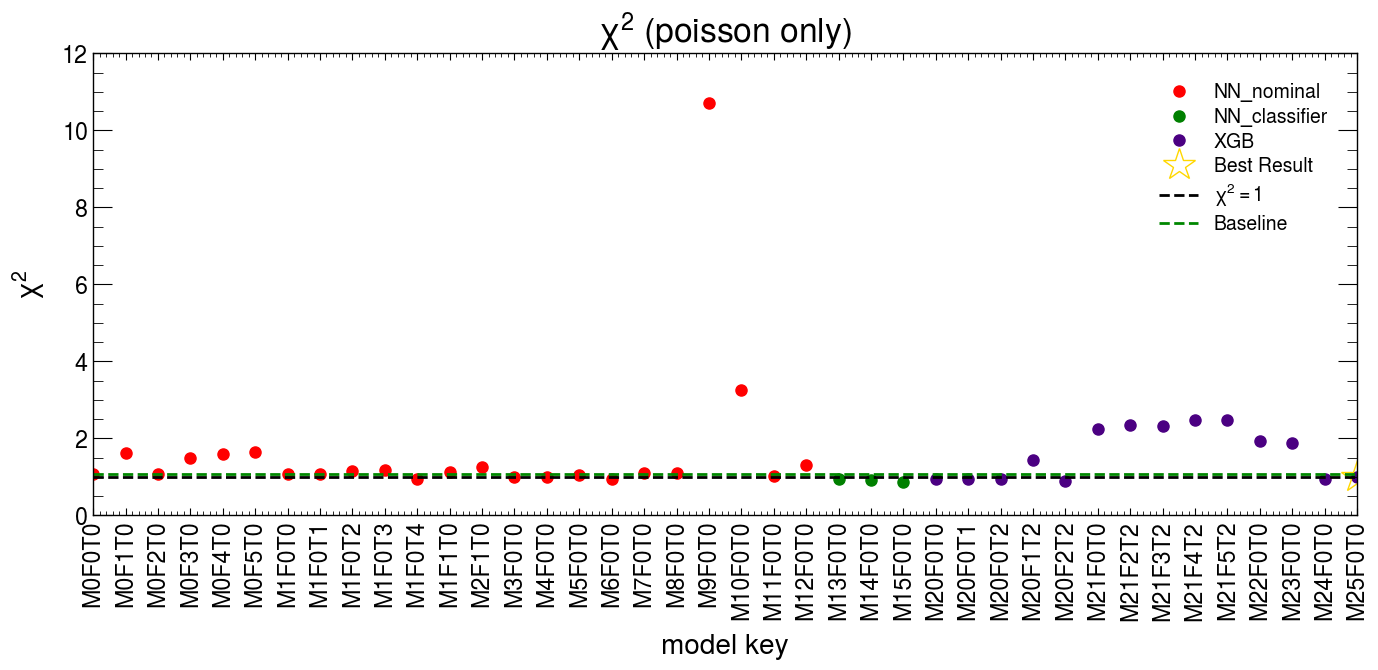

In [58]:
plt.subplots(figsize=(16,6))
nn_nominal_count=0
nn_classifier_count=0
xgb_count=0
for i, (k, v) in enumerate(chis2_all.items()):
    if model_types[i] == 'NN_nominal':
        if nn_nominal_count == 0:
            plt.plot(k, v, 'o', color = 'red', label = 'NN_nominal')
            nn_nominal_count+=1
        else:
            plt.plot(k, v, 'o', color='red')
    elif model_types[i] == 'NN_classifier':
        if nn_classifier_count==0:
            plt.plot(k, v, 'o', color = 'green', label ='NN_classifier')
            nn_classifier_count+=1
        else:
            plt.plot(k, v, 'o', color = 'green')
    elif model_types[i] == 'XGB':
        if xgb_count==0:
            plt.plot(k, v, 'o', color = 'indigo', label = 'XGB')
            xgb_count+=1
        else:
            plt.plot(k, v, 'o', color='indigo')
plt.plot(chis2_all_df.iloc[0,0], chis2_all_df.iloc[0, 1], '*', markersize=24, markeredgecolor='gold', markerfacecolor='none', label = 'Best Result')
plt.axhline(1, color='black', ls ='--', label = '$\chi^2 = 1$')
plt.axhline(chis2_all["M0F0T0"], label = 'Baseline', ls = "--")
plt.title(r'$\chi^2$ (poisson only)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)
plt.legend()

(0.0, 3.0)

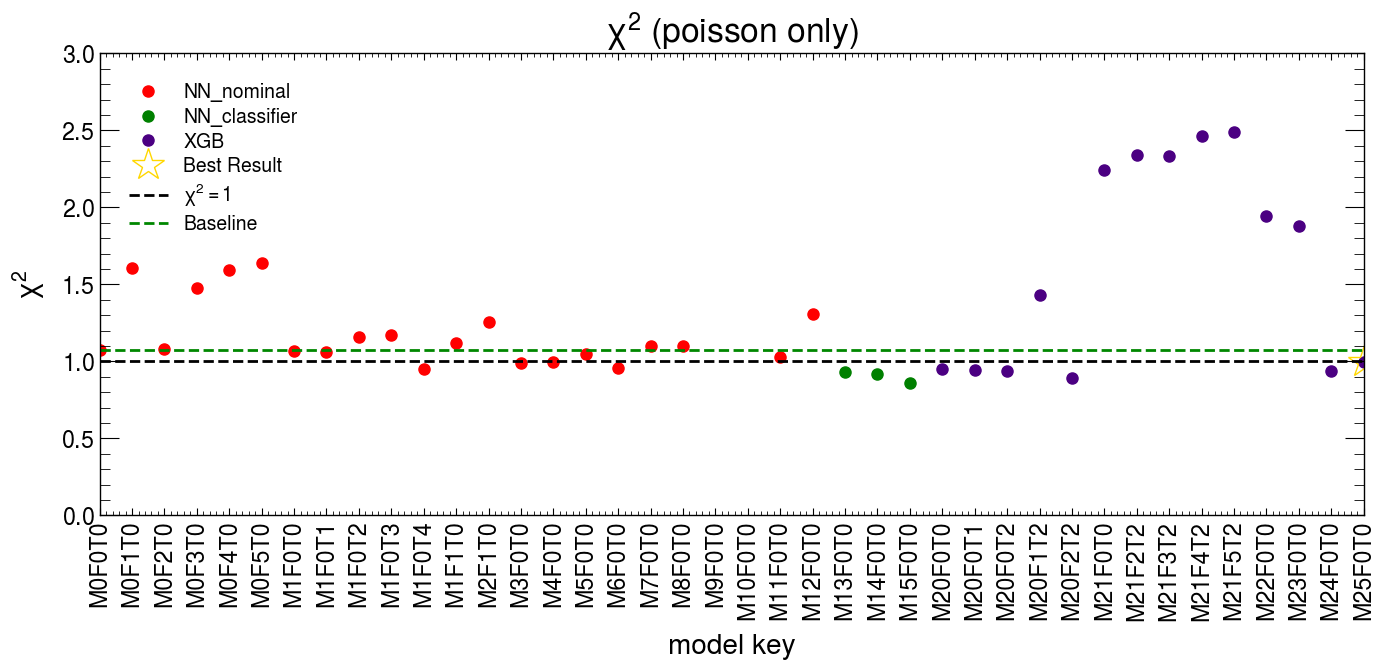

In [64]:
plt.subplots(figsize=(16,6))
nn_nominal_count=0
nn_classifier_count=0
xgb_count=0
for i, (k, v) in enumerate(chis2_all.items()):
    if model_types[i] == 'NN_nominal':
        if nn_nominal_count == 0:
            plt.plot(k, v, 'o', color = 'red', label = 'NN_nominal')
            nn_nominal_count+=1
        else:
            plt.plot(k, v, 'o', color='red')
    elif model_types[i] == 'NN_classifier':
        if nn_classifier_count==0:
            plt.plot(k, v, 'o', color = 'green', label ='NN_classifier')
            nn_classifier_count+=1
        else:
            plt.plot(k, v, 'o', color = 'green')
    elif model_types[i] == 'XGB':
        if xgb_count==0:
            plt.plot(k, v, 'o', color = 'indigo', label = 'XGB')
            xgb_count+=1
        else:
            plt.plot(k, v, 'o', color='indigo')
plt.plot(chis2_all_df.iloc[0,0], chis2_all_df.iloc[0, 1], '*', markersize=24, markeredgecolor='gold', markerfacecolor='none', label = 'Best Result')
plt.axhline(1, color='black', ls ='--', label = '$\chi^2 = 1$')
plt.axhline(chis2_all["M0F0T0"], label = 'Baseline', ls = "--")
plt.title(r'$\chi^2$ (poisson only)')
plt.ylabel(r'$\chi^2$')
plt.xlabel('model key')
_=plt.xticks(rotation=90)
plt.legend()
plt.ylim(0,3)

## WITH BOOTSTRAP ERROR

(0.0, 3.0)

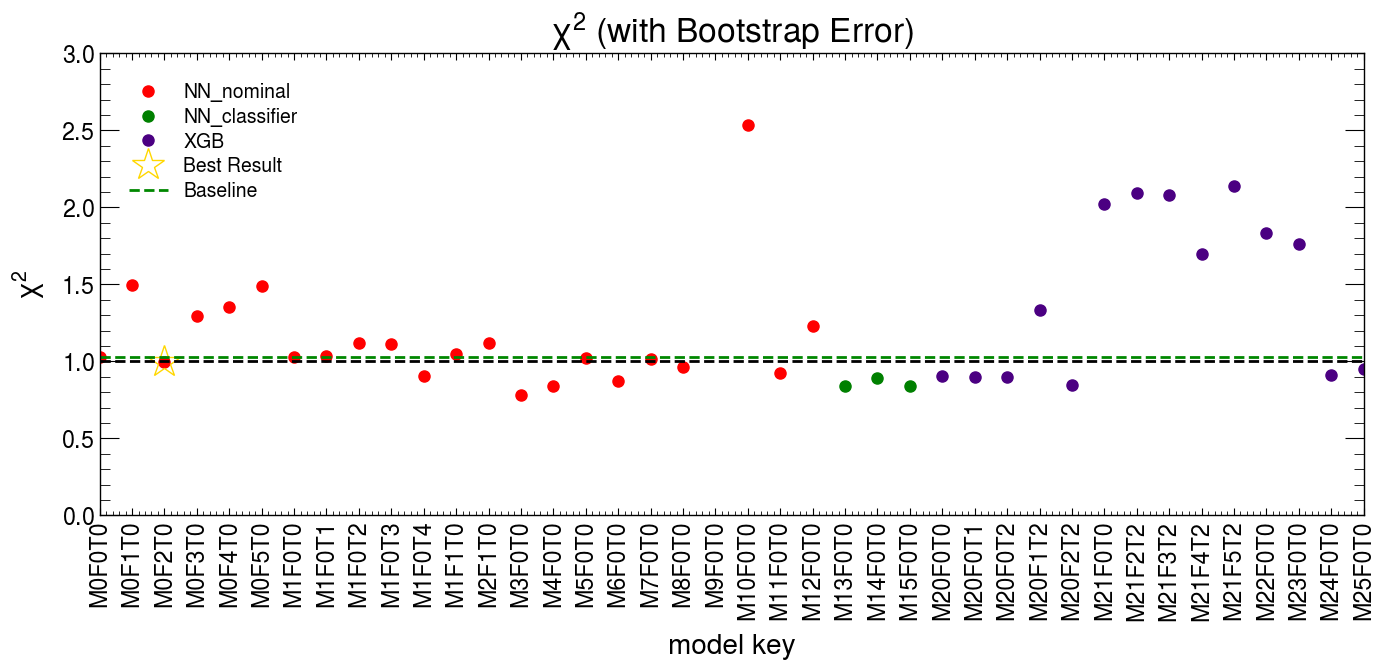

In [65]:
plt.subplots(figsize=(16, 6))
nn_nominal_count = 0
nn_classifier_count = 0
xgb_count = 0
for i, (k, v) in enumerate(chis2_bs_all.items()):
    if model_types[i] == "NN_nominal":
        if nn_nominal_count == 0:
            plt.plot(k, v, "o", color="red", label="NN_nominal")
            nn_nominal_count += 1
        else:
            plt.plot(k, v, "o", color="red")
    elif model_types[i] == "NN_classifier":
        if nn_classifier_count == 0:
            plt.plot(k, v, "o", color="green", label="NN_classifier")
            nn_classifier_count += 1
        else:
            plt.plot(k, v, "o", color="green")
    elif model_types[i] == "XGB":
        if xgb_count == 0:
            plt.plot(k, v, "o", color="indigo", label="XGB")
            xgb_count += 1
        else:
            plt.plot(k, v, "o", color="indigo")
chis2_bs_all_df = pd.DataFrame(
    {
        "model_key": chis2_bs_all.keys(),
        "chi2": chis2_bs_all.values(),
        "diff": np.abs((1 - np.array(list(chis2_bs_all.values())))),
    }
).sort_values(by="diff", ascending=True)
plt.plot(
    chis2_bs_all_df.iloc[0, 0],
    chis2_bs_all_df.iloc[0, 1],
    "*",
    markersize=24,
    markeredgecolor="gold",
    markerfacecolor="none",
    label="Best Result",
)
plt.axhline(1, color="black", ls="--")
plt.axhline(chis2_bs_all["M0F0T0"], label="Baseline", ls="--")
plt.title(r"$\chi^2$ (with Bootstrap Error)")
plt.ylabel(r"$\chi^2$")
plt.xlabel("model key")
_ = plt.xticks(rotation=90)
plt.legend()
plt.ylim(0,3)

## Including Shape Systematic

(0.0, 3.0)

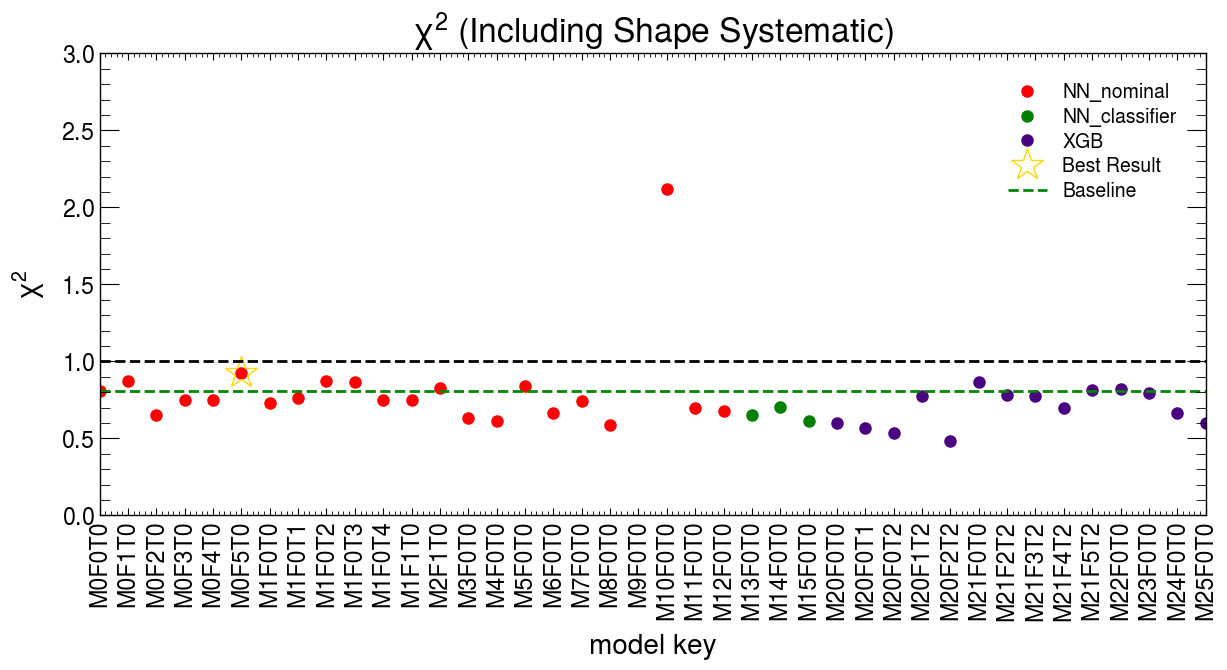

In [66]:
plt.subplots(figsize=(14, 6))
nn_nominal_count = 0
nn_classifier_count = 0
xgb_count = 0
for i, (k, v) in enumerate(chis2_shape_all.items()):
    if model_types[i] == "NN_nominal":
        if nn_nominal_count == 0:
            plt.plot(k, v, "o", color="red", label="NN_nominal")
            nn_nominal_count += 1
        else:
            plt.plot(k, v, "o", color="red")
    elif model_types[i] == "NN_classifier":
        if nn_classifier_count == 0:
            plt.plot(k, v, "o", color="green", label="NN_classifier")
            nn_classifier_count += 1
        else:
            plt.plot(k, v, "o", color="green")
    elif model_types[i] == "XGB":
        if xgb_count == 0:
            plt.plot(k, v, "o", color="indigo", label="XGB")
            xgb_count += 1
        else:
            plt.plot(k, v, "o", color="indigo")
chis2_shape_all_df = pd.DataFrame(
    {
        "model_key": chis2_shape_all.keys(),
        "chi2": chis2_shape_all.values(),
        "diff": np.abs(1 - np.array(list(chis2_shape_all.values()))),
    }
).sort_values(by="diff", ascending=True)
plt.plot(
    chis2_shape_all_df.iloc[0, 0],
    chis2_shape_all_df.iloc[0, 1],
    "*",
    markersize=24,
    markeredgecolor="gold",
    markerfacecolor="none",
    label = 'Best Result'
)
plt.axhline(1, color="black", ls="--")
plt.axhline(chis2_shape_all["M0F0T0"], label="Baseline", ls="--")
plt.title(r"$\chi^2$ (Including Shape Systematic)")
plt.ylabel(r"$\chi^2$")
plt.xlabel("model key")
_ = plt.xticks(rotation=90)
plt.legend()
plt.ylim(0,3)

# BOOTSTRAP ERROR

In [67]:
model_bs_error = {}
model_shape_error = {}
histograms_mhh_2b = {}
bs_perc_err_2b = {}
shape_perc_err_2b = {}
be = np.linspace(250, 1200, 51)
x = 0.5 * (be[:-1] + be[1:])
for model in models_keys_17:
    print(model)

    weight_col = w_col(17, weight_label=model)
    weight_iqr_col = w_iqr(17, weight_label=model)
    mu_med = get_norm(df17, 17, weight_label=model)
    mu_IQR = get_norm_iqr(df17, 17, weight_label=model)
    bs_err = bs_error(
        df17,
        kr=2,
        be=be,
        W_med=weight_col,
        W_IQR=weight_iqr_col,
        mu_med=mu_med,
        mu_IQR=mu_IQR,
        feature="m_hh",
    )["h_err_bs_mag"]

    h_mhh_2b = histogram_2b(df17, "m_hh", 2, mu_med, weight_col, be)

    shape_err = shape_systematic(
        df17,
        "m_hh",
        2,
        be,
        CR_weights=w_col(17, weight_label=model),
        VR_weights=w_col(17, vr=True, weight_label=model),
    )['shape_err']

    model_bs_error[model] = np.abs(bs_err)
    model_shape_error[model] = shape_err
    histograms_mhh_2b[model] = h_mhh_2b["h_2b"]
    bs_perc_err_2b[model] = 100 * np.abs(bs_err) / h_mhh_2b["h_2b"]
    shape_perc_err_2b[model] = 100 * shape_err / h_mhh_2b['h_2b']

M0F0T0
M0F1T0
M0F2T0
M0F3T0
M0F4T0
M0F5T0
M1F0T0
M1F0T1
M1F0T2
M1F0T3
M1F0T4
M1F1T0
M2F1T0
M3F0T0
M4F0T0
M5F0T0
M6F0T0
M7F0T0
M8F0T0
M9F0T0
M10F0T0
M11F0T0
M12F0T0
M13F0T0
M14F0T0
M15F0T0
M20F0T0
M20F0T1
M20F0T2
M20F1T2
M20F2T2
M21F0T0
M21F2T2
M21F3T2
M21F4T2
M21F5T2
M22F0T0
M23F0T0
M24F0T0
M25F0T0


In [68]:
from matplotlib import cm
evenly_spaced_interval = np.linspace(0, 1, 5)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

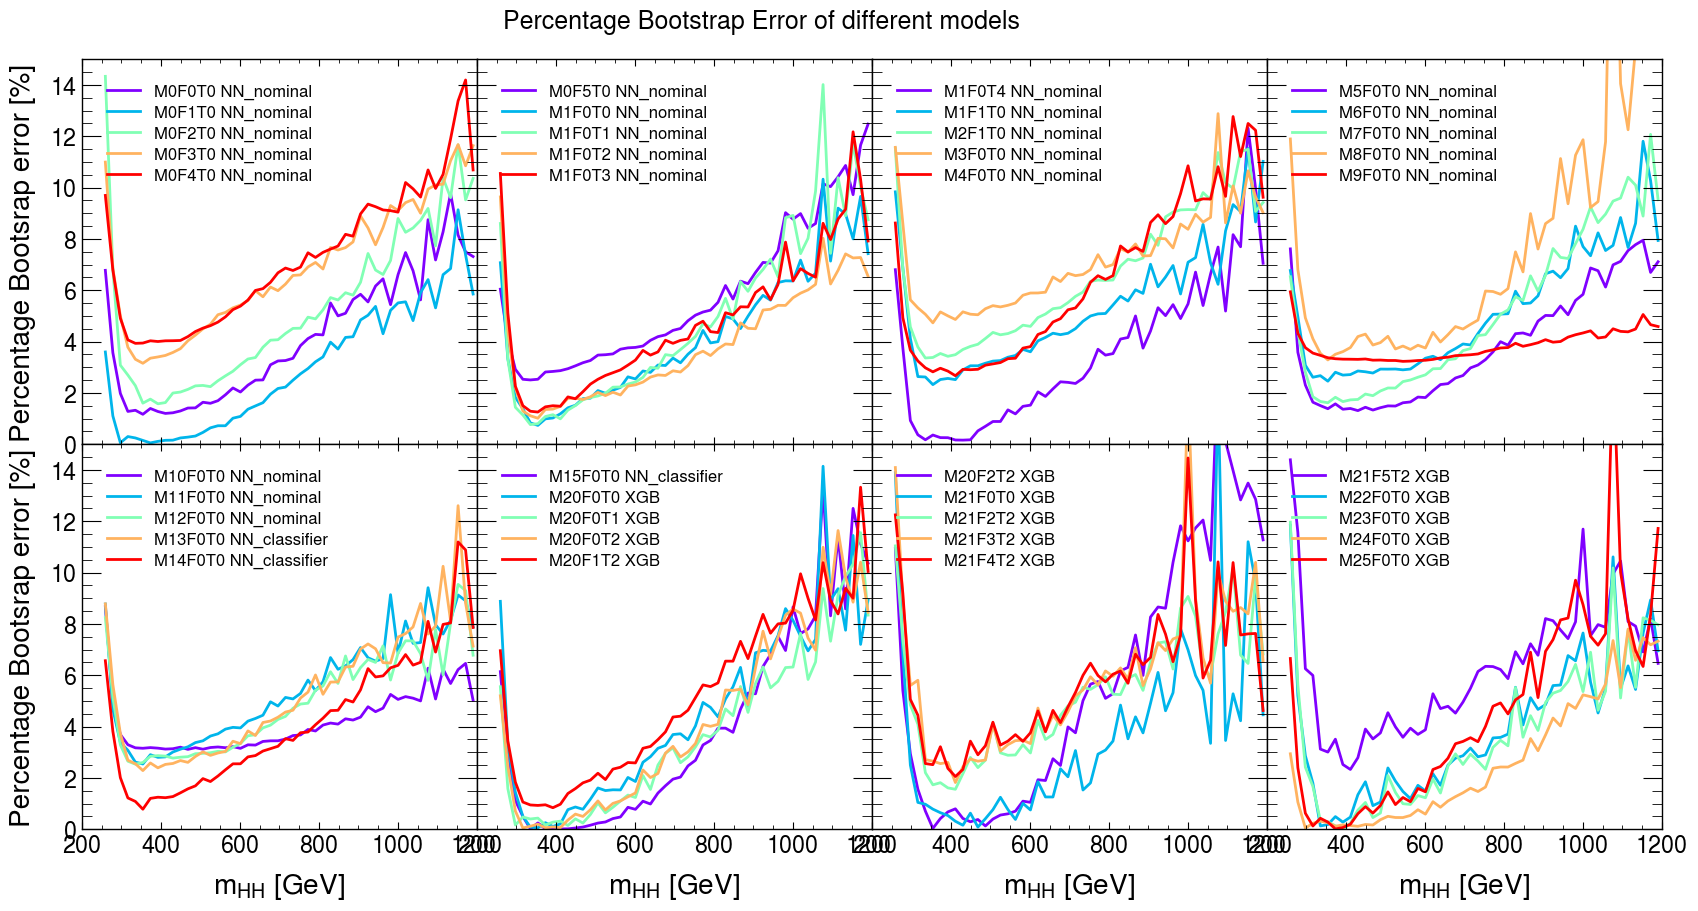

In [70]:
f, ax = plt.subplots(2,4, figsize= (20,10), sharex=True, sharey=True)


h_err = np.array(list(bs_perc_err_2b.values()))
for i, (m_k, m_t) in enumerate(zip(models_keys_17, model_types)):
    label = m_k + ' ' + m_t
    if i < 5:
        _ = ax[0,0].plot(x, h_err[i, :], label = label, color=colors[i%5])
        ax[0,0].set_ylim(0, 15)
    elif i >= 5 and i < 10:
        _ = ax[0,1].plot(x, h_err[i, :], label = label, color=colors[i%5])
    elif i >= 10 and i < 15:
        _ = ax[0,2].plot(x, h_err[i, :], label = label, color =colors[i%5])
    elif i >= 15 and i < 20:
        _ = ax[0,3].plot(x, h_err[i, :], label = label, color = colors[i%5])
    elif i >= 20 and i < 25:
        _ = ax[1,0].plot(x, h_err[i, :], label = label, color = colors[i%5])
    elif i >= 25 and i < 30:
        _ = ax[1,1].plot(x, h_err[i, :], label = label, color = colors[i%5])
    elif i >= 30 and i < 35:
        _ = ax[1,2].plot(x, h_err[i, :], label = label, color = colors[i%5])
    elif i >= 35 and i < 40:
        _ = ax[1,3].plot(x, h_err[i, :], label = label, color = colors[i%5])

for i in range(2):
    for j in range(4):
        ax[i,j].legend(loc = 'upper left', fontsize = 12)
        
plt.subplots_adjust(wspace=0, hspace=0)
ax[0,0].set_ylabel('Percentage Bootsrap error [%]')
ax[1,0].set_ylabel('Percentage Bootsrap error [%]')
ax[1,0].set_xlabel(r'$m_{HH}$ [GeV]')
ax[1,1].set_xlabel(r'$m_{HH}$ [GeV]')
ax[1,2].set_xlabel(r'$m_{HH}$ [GeV]')
ax[1,3].set_xlabel(r'$m_{HH}$ [GeV]')
_ = f.suptitle('Percentage Bootstrap Error of different models', fontsize=18)